In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import time
import datetime

import tensorflow as tf
from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

from util.custom_callbacks import SkipLoggerCallback,LearningRateHistoryCallback

import matplotlib.pyplot as plt

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

In [4]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [5]:
def define_model_architecture_64_32_16(sgd_optimizer = 'sgd'):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
sgd = optimizers.SGD(lr=0.01)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 52,882
Trainable params: 52,882
Non-trainable params: 0
_________________________________________________________________


In [7]:
!rm -rf ./logs/

In [8]:
skipLogger_callback = SkipLoggerCallback(n=25)

### tuning learning rates for mini batch gradient descent

Typical values for the learning rate are in the range of 0.1 to 1e-6, though the optimal learning rate is usually data (and network architecture) specific. Some simple advice is to start by trying three different learning rates – 1e-1, 1e-3, and 1e-6 – to get a rough idea of what it should be, before further tuning this.

In [9]:
learning_rates = [1e-1,1e-2,1e-3,1e-6]
learning_history_dict = {}
training_time_dict = {}
EPOCHS = 500

In [10]:
for learning_rate in learning_rates:
    print('working with learning rate : %f' % learning_rate)
    print('')
    
    sgd = optimizers.SGD(lr=learning_rate)
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = [skipLogger_callback, tb_callback])
    training_time_dict[str(learning_rate)] = time.time() - start
    learning_history_dict[str(learning_rate)] = history
    
    print('-'*120)

working with learning rate : 0.100000



W0828 11:16:36.717009 139726672525120 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.739569    accuracy = 0.56    val_loss = 0.729354    val_accuracy = 0.49
epoch =   50    loss = 0.493908    accuracy = 0.77    val_loss = 0.524037    val_accuracy = 0.74
epoch =  100    loss = 0.477316    accuracy = 0.78    val_loss = 0.505276    val_accuracy = 0.77
epoch =  150    loss = 0.443971    accuracy = 0.80    val_loss = 0.506358    val_accuracy = 0.76
epoch =  200    loss = 0.401382    accuracy = 0.82    val_loss = 0.485928    val_accuracy = 0.77
epoch =  250    loss = 0.402392    accuracy = 0.81    val_loss = 0.456616    val_accuracy = 0.81
epoch =  300    loss = 0.380052    accuracy = 0.83    val_loss = 0.444667    val_accuracy = 0.83
epoch =  350    loss = 0.363750    accuracy = 0.84    val_loss = 0.413510    val_accuracy = 0.81
epoch =  400    loss = 0.359890    accuracy = 0.84    val_loss = 0.392823    val_accuracy = 0.81
epoch =  450    loss = 0.346902    accuracy = 0.84    val_loss = 0.448135    val_accuracy = 0.81
------------------------------

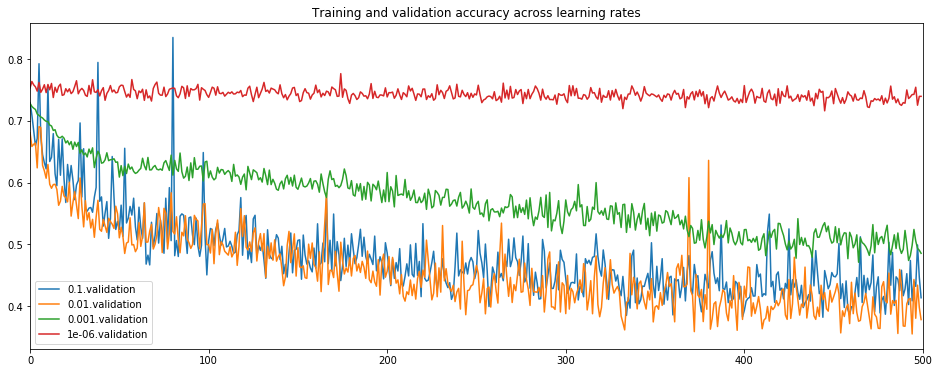

In [13]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    #plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation accuracy across learning rates')
plt.xlim(0, EPOCHS)
plt.show()

In [12]:
training_time_dict

{'0.1': 2842.8192245960236,
 '0.01': 2810.342999458313,
 '0.001': 2837.1881291866302,
 '1e-06': 2912.2441442012787}

#### Observations ####

1. optimal learning rate is between 0.001 and 0.01

### Finding optimal learning rate

The automatic learning rate finder algorithm works like this:

Step 1: We start by defining an upper and lower bound on our learning rate. The lower bound should be very small (1e-10) and the upper bound should be very large (1e+1).At 1e-10 the learning rate will be too small for our network to learn, while at 1e+1 the learning rate will be too large and our model will overfit.Both of these are okay, and in fact, that’s what we hope to see!

Step 2: We then start training our network, starting at the lower bound.After each batch update, we exponentially increase our learning rate.We log the loss after each batch update as well.

Step 3: Training continues, and therefore the learning rate continues to increase until we hit our maximum learning rate value.
Typically, this entire training process/learning rate increase only takes 1-5 epochs.

Step 4: After training is complete we plot a smoothed loss over time, enabling us to see when the learning rate is both:
Just large enough for loss to decrease And too large, to the point where loss starts to increase.

In [9]:
from util.learningratefinder import LearningRateFinder

In [10]:
sgd = optimizers.SGD(lr=0.01)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)

In [12]:
lrf = LearningRateFinder(model)
lrf.find(train_batches,1e-10, 1e+1, stepsPerEpoch=train_batches.samples/BATCH_SIZE, batchSize=BATCH_SIZE, verbose=2)

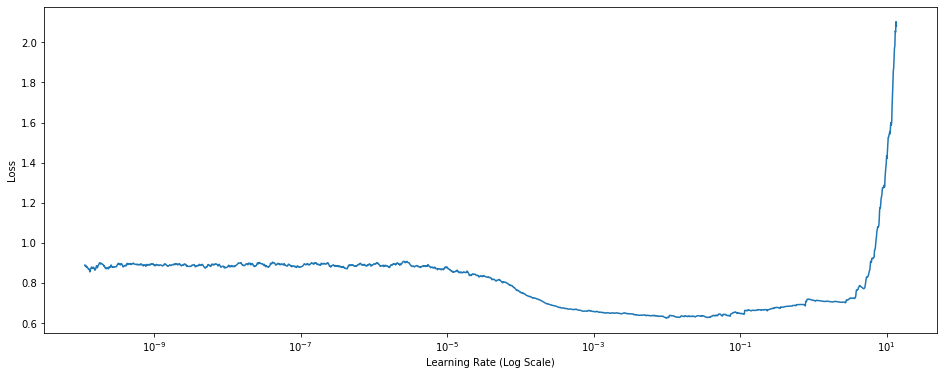

In [13]:
lrf.plot_loss()

Optimum learning rate is from 1e-5 to 1e-2 

decay equation : # lr_with_decay = lr * (1/(1+decay*iteration))                
((lr / lr_with_decay) - 1)/iteration = decay

### Learn at static learnig rate 0.0066
This is the learning rate where batch loss is quickly decreasing 

In [9]:
sgd = optimizers.SGD(lr=0.0066)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)

In [12]:
!rm -rf ./logs/
EPOCHS = 600
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_history_callback = LearningRateHistoryCallback()
callback_list = [lr_history_callback, tb_callback, skipLogger_callback]
    
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
print('time taken : %.4f' % (time.time() - start))

W0829 17:48:50.788634 139981064365888 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.697908    accuracy = 0.53    val_loss = 0.713283    val_accuracy = 0.57
epoch =   25    loss = 0.574673    accuracy = 0.70    val_loss = 0.600503    val_accuracy = 0.70
epoch =   50    loss = 0.535595    accuracy = 0.73    val_loss = 0.614400    val_accuracy = 0.65
epoch =   75    loss = 0.490929    accuracy = 0.77    val_loss = 0.565043    val_accuracy = 0.75
epoch =  100    loss = 0.464472    accuracy = 0.78    val_loss = 0.506126    val_accuracy = 0.79
epoch =  125    loss = 0.446311    accuracy = 0.80    val_loss = 0.531711    val_accuracy = 0.75
epoch =  150    loss = 0.432064    accuracy = 0.80    val_loss = 0.454489    val_accuracy = 0.82
epoch =  175    loss = 0.424753    accuracy = 0.81    val_loss = 0.452022    val_accuracy = 0.79
epoch =  200    loss = 0.421423    accuracy = 0.81    val_loss = 0.563604    val_accuracy = 0.73
epoch =  225    loss = 0.409979    accuracy = 0.83    val_loss = 0.521737    val_accuracy = 0.75
epoch =  250    loss = 0.38877

In [13]:
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

Test loss: 0.3250 accuracy: 0.8620


In [14]:
model.save("model/model_lr_tune_static_cross_valid_600.h5")

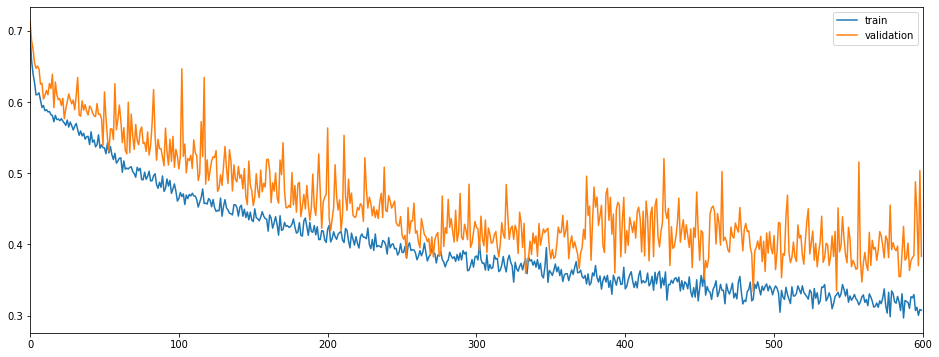

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.show()

### Using Decay in learning rate
start with 1e-2. Estimate there are 2500 epochs. Higher number of epochs assumed so that learning rate decay is not substantial. 1e-3 is targeted rate at 2500 epochs, starting from 1e-2. But model will be trained till 700 epochs.

In [17]:
1e-2/500

2e-05

In [23]:
MAX_EPOCHS = 3000
iteration = int(train_batches.samples/BATCH_SIZE)*MAX_EPOCHS
learning_rate_start = 1e-2
learning_rate_end = 1e-3
decay = ((learning_rate_start/learning_rate_end) - 1)/iteration
print('computed decay : %.2e' % decay)

computed decay : 5.26e-05


In [24]:
sgd = optimizers.SGD(lr=1e-2, decay=5.2e-5)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)

In [25]:
!rm -rf ./logs/

In [29]:
EPOCHS = 700
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
lr_history_callback = LearningRateHistoryCallback()
callback_list = [lr_history_callback, tb_callback, skipLogger_callback]
    
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
print('time taken : %.4f' % (time.time() - start))

epoch =    0    loss = 0.610369    accuracy = 0.67    val_loss = 0.658831    val_accuracy = 0.67
epoch =   25    loss = 0.534753    accuracy = 0.74    val_loss = 0.557590    val_accuracy = 0.74
epoch =   50    loss = 0.500301    accuracy = 0.77    val_loss = 0.493428    val_accuracy = 0.80
epoch =   75    loss = 0.466138    accuracy = 0.80    val_loss = 0.503203    val_accuracy = 0.78
epoch =  100    loss = 0.447740    accuracy = 0.79    val_loss = 0.498089    val_accuracy = 0.79
epoch =  125    loss = 0.433390    accuracy = 0.81    val_loss = 0.578709    val_accuracy = 0.75
epoch =  150    loss = 0.421977    accuracy = 0.81    val_loss = 0.489050    val_accuracy = 0.79
epoch =  175    loss = 0.408202    accuracy = 0.81    val_loss = 0.479225    val_accuracy = 0.79
epoch =  200    loss = 0.394346    accuracy = 0.83    val_loss = 0.479713    val_accuracy = 0.81
epoch =  225    loss = 0.386932    accuracy = 0.83    val_loss = 0.429226    val_accuracy = 0.82
epoch =  250    loss = 0.38164

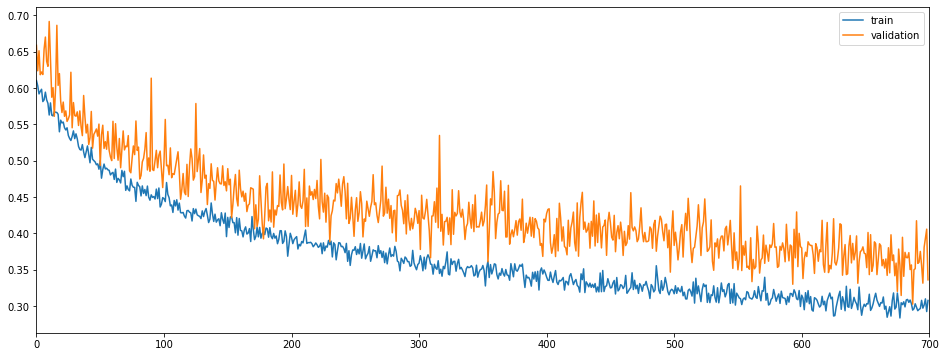

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.show()

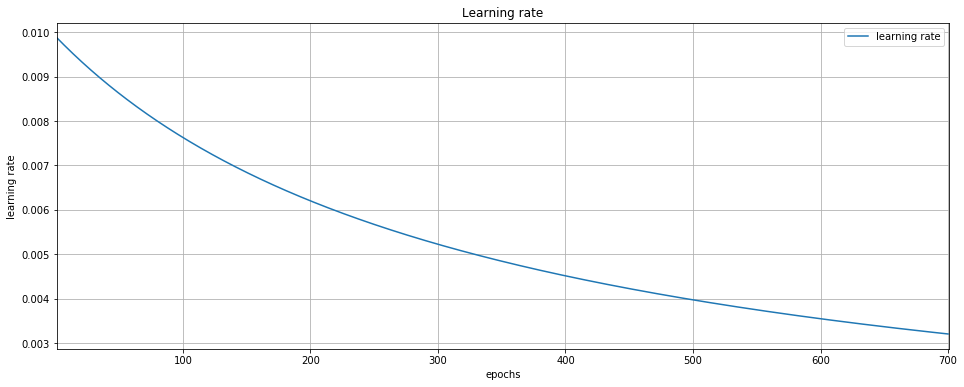

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(range(1,EPOCHS+1), lr_history_callback.lr, label='learning rate')
plt.xlabel("epochs")
plt.xlim([1,EPOCHS+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [32]:
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

Test loss: 0.3281 accuracy: 0.8589


In [33]:
model.save("model/model_lr_decay_cross_valid_600.h5")